In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import os
import seaborn as sns

file_path = "C:/Users/ajeva/Downloads/archive/combined_nhis_dataset_with_fraud_types (1).csv"
df = pd.read_csv(file_path)
print("Loaded dataset shape:", df.shape)
df.head()


Loaded dataset shape: (20388, 8)


,Patient ID,AGE,GENDER,DATE OF ENCOUNTER,DATE OF DISCHARGE,Amount Billed,DIAGNOSIS,FRAUD_TYPE
0,1,25.0,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing
1,2,30.0,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis
2,3,35.0,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis
3,4,48.0,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee
4,5,58.0,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud


In [3]:

print("Columns and dtypes:\n")
print(df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nUnique values per column:\n", df.nunique())


Columns and dtypes:

Patient ID             int64
AGE                  float64
GENDER                object
DATE OF ENCOUNTER     object
DATE OF DISCHARGE     object
Amount Billed        float64
DIAGNOSIS             object
FRAUD_TYPE            object
dtype: object

Missing values per column:
 Patient ID             0
AGE                    0
GENDER                 0
DATE OF ENCOUNTER    541
DATE OF DISCHARGE    659
Amount Billed          0
DIAGNOSIS             38
FRAUD_TYPE             0
dtype: int64

Unique values per column:
 Patient ID           20000
AGE                     96
GENDER                   6
DATE OF ENCOUNTER     2634
DATE OF DISCHARGE     2639
Amount Billed        10888
DIAGNOSIS             1771
FRAUD_TYPE               4
dtype: int64


In [4]:

# Standardize column names
df.columns = [c.strip().replace(' ', '_').lower() for c in df.columns]

# Rename for consistency
df = df.rename(columns={
    'patient_id':'patient_id',
    'age':'age',
    'gender':'gender',
    'date_of_encounter':'date_of_encounter',
    'date_of_discharge':'date_of_discharge',
    'amount_billed':'amount_billed',
    'diagnosis':'diagnosis',
    'fraud_type':'fraud_type'
})

# Gender cleaning: only keep M and F
df['gender'] = df['gender'].astype(str).str.strip().str.upper()
df['gender'] = df['gender'].replace({
    'MF': np.nan,
    'FF': 'F',
    'M': 'M',
    'F': 'F'
})
df = df[df['gender'].isin(['M', 'F'])]

# Create binary fraud flag
df['is_fraud'] = (df['fraud_type'].str.strip().str.lower() != 'no fraud').astype(int)

# Parse dates and compute length of stay
df['date_of_encounter'] = pd.to_datetime(df['date_of_encounter'], errors='coerce')
df['date_of_discharge'] = pd.to_datetime(df['date_of_discharge'], errors='coerce')
df['length_of_stay'] = (df['date_of_discharge'] - df['date_of_encounter']).dt.days

print("Gender cleaned and data prepared. Unique gender values:")
print(df['gender'].value_counts(dropna=False))
df.head()


Gender cleaned and data prepared. Unique gender values:
gender
F    10629
M     9758
Name: count, dtype: int64


,patient_id,age,gender,date_of_encounter,date_of_discharge,amount_billed,diagnosis,fraud_type,is_fraud,length_of_stay
0,1,25.0,F,2025-02-11,2025-02-11,16800.0,CYESIS LMP,Phantom Billing,1,0.0
1,2,30.0,M,2025-02-13,2025-02-13,6300.0,WAX IMPACTION,Wrong Diagnosis,1,0.0
2,3,35.0,M,2025-02-13,2025-02-13,6160.0,CYESIS LMP,Wrong Diagnosis,1,0.0
3,4,48.0,M,2025-02-18,2025-02-18,0.0,TONSILITIS OBSTRUCTIVE SLEEP APEANA,Ghost Enrollee,1,0.0
4,5,58.0,F,2025-02-18,2025-02-18,8400.0,REFRACTIVE ERROR,No Fraud,0,0.0


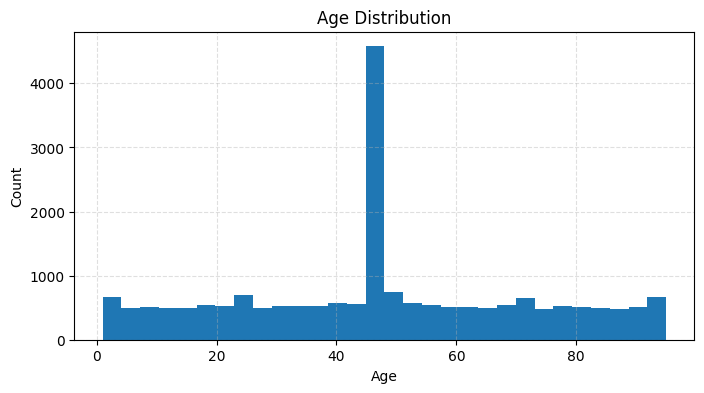

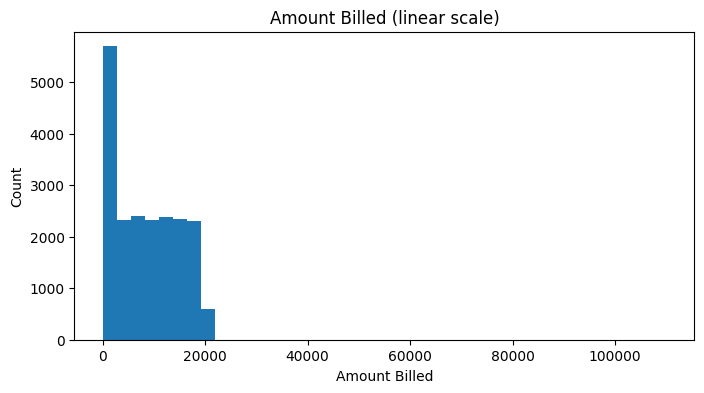

In [23]:

plt.figure(figsize=(8,4))
plt.hist(df['age'].dropna(), bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig("age distribution.png")
plt.show()


plt.figure(figsize=(8,4))
plt.hist(df['amount_billed'].dropna(), bins=40)
plt.title('Amount Billed (linear scale)')
plt.xlabel('Amount Billed')
plt.ylabel('Count')
plt.savefig("amount billed.png")
plt.show()



In [6]:

fraud_counts = df['fraud_type'].value_counts(dropna=False).rename_axis('fraud_type').reset_index(name='count')
fraud_counts['pct'] = fraud_counts['count'] / len(df) * 100
print(fraud_counts)
print("\nOverall fraud rate: {:.2f}%".format(df['is_fraud'].mean() * 100))


        fraud_type  count        pct
0         No Fraud  11704  57.409133
1  Phantom Billing   4233  20.763231
2   Ghost Enrollee   4098  20.101045
3  Wrong Diagnosis    352   1.726590

Overall fraud rate: 42.59%


C:\Users\ajeva\AppData\Local\Temp\ipykernel_3984\4170737238.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=['No Fraud', 'Fraud'], showfliers=False)


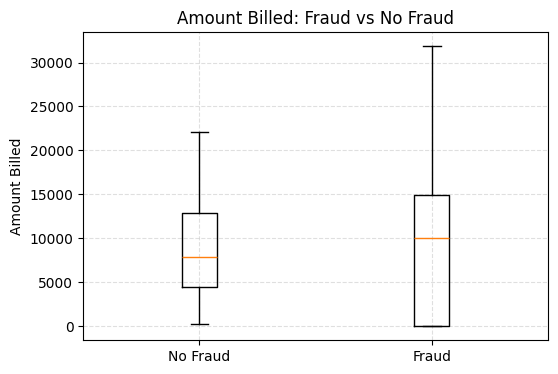

In [25]:

groups = [df.loc[df['is_fraud']==0, 'amount_billed'].dropna(), df.loc[df['is_fraud']==1, 'amount_billed'].dropna()]
plt.figure(figsize=(6,4))
plt.boxplot(groups, labels=['No Fraud', 'Fraud'], showfliers=False)
plt.title('Amount Billed: Fraud vs No Fraud')
plt.ylabel('Amount Billed')
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig("amount billed fraud vs no fraud.png")
plt.show()


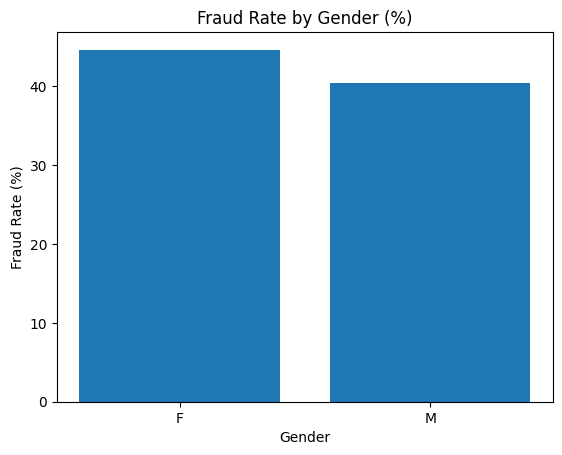

<Figure size 640x480 with 0 Axes>

In [19]:

gender_summary = df.groupby('gender')['is_fraud'].mean().reset_index()
gender_summary['fraud_rate_pct'] = gender_summary['is_fraud'] * 100
plt.bar(gender_summary['gender'], gender_summary['fraud_rate_pct'])
plt.title('Fraud Rate by Gender (%)')
plt.xlabel('Gender')
plt.ylabel('Fraud Rate (%)')
plt.savefig("fraud rate by gender.png")
plt.show()


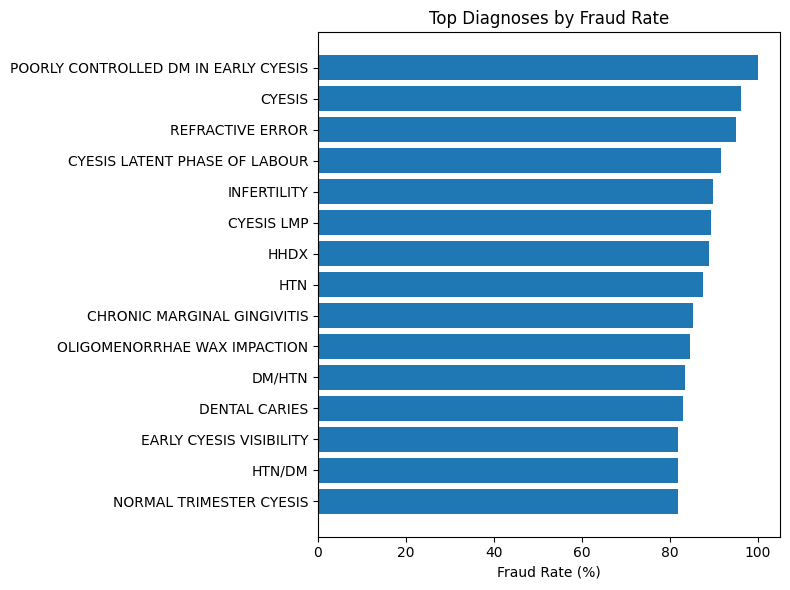

In [26]:

min_count = 10
diag_stats = df.groupby('diagnosis').agg(total_claims=('patient_id','count'), fraud_claims=('is_fraud','sum')).reset_index()
diag_stats['fraud_rate'] = diag_stats['fraud_claims'] / diag_stats['total_claims'] * 100
top_diag = diag_stats[diag_stats['total_claims'] >= min_count].sort_values('fraud_rate', ascending=False).head(15)

plt.figure(figsize=(8,6))
plt.barh(top_diag['diagnosis'][::-1], top_diag['fraud_rate'][::-1])
plt.xlabel('Fraud Rate (%)')
plt.title('Top Diagnoses by Fraud Rate')
plt.tight_layout()
plt.savefig("top diagnoses by fraud rate.png")
plt.show()


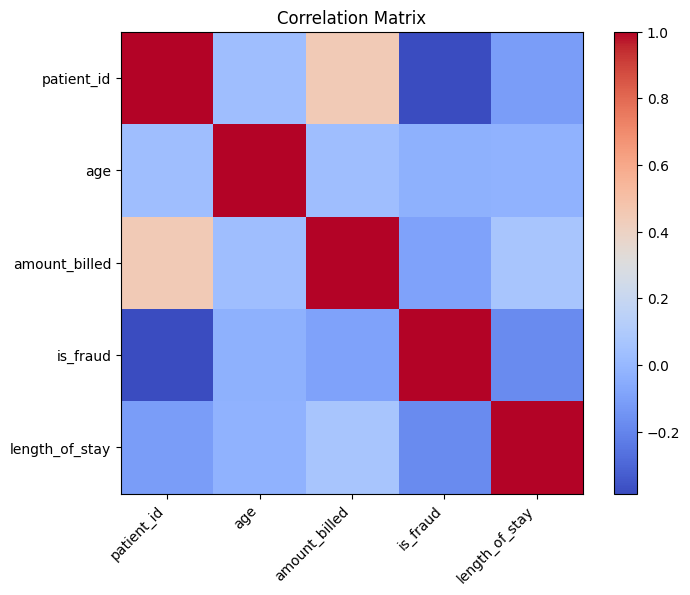

In [27]:

num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title('Correlation Matrix')
plt.savefig("correlation matrix.png")
plt.show()

In [11]:

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1),(rcorr-1))
    return np.sqrt(phi2corr/denom) if denom != 0 else np.nan

for col in ['gender','diagnosis']:
    val = cramers_v(df[col].fillna('MISSING'), df['is_fraud'])
    print(f"Cramer's V between {col} and is_fraud: {val:.3f}")


Cramer's V between gender and is_fraud: 0.042
Cramer's V between diagnosis and is_fraud: 0.283


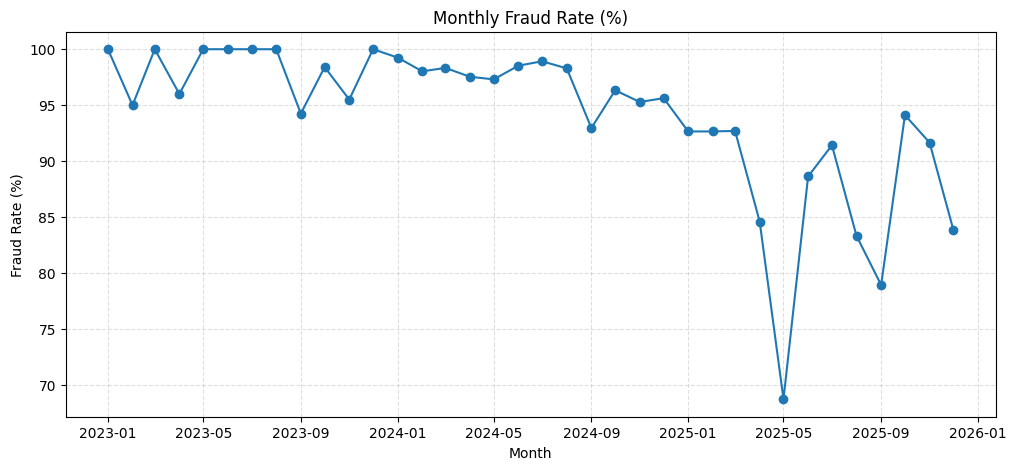

In [28]:

if 'date_of_discharge' in df.columns:
    df['month'] = df['date_of_discharge'].dt.to_period('M').dt.to_timestamp()
    monthly = df.groupby('month')['is_fraud'].mean() * 100
    plt.figure(figsize=(12, 5))
    plt.plot(monthly.index, monthly.values, marker='o')
    plt.title('Monthly Fraud Rate (%)')
    plt.xlabel('Month')
    plt.ylabel('Fraud Rate (%)')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.savefig("monthly fraud rate.png")
    plt.show()
